In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime
import plotly.express as px
import sklearn

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import eli5 # Feature importance evaluation

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

from sklearn.metrics import make_scorer
from xgboost import plot_importance

C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.
C:\Users\alexs\.conda\envs\Alex_R\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ve

In [2]:
#Definimos el concepto de tn, tp, fn y fp en una matriz de confusión binaria para poder extraerlos en cada iteración del CV:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

# 8. Random Forest

### 8.1 Definimos dataset

In [3]:
#Importamos el dataset final
df_final = pd.read_csv("df_final.csv")

In [4]:
df_final.shape

(70349, 23)

### 9.2 Reducir atributos

En este apartado vamos ver cuales son los atributos mas importantes para el modelo. Con esta información podremos ver si el modelo con menos variables es igual de bueno o no. De esta manera tendremos un atributo mucho mas simple y rapido.

Empezamos teniendo los 22 atributos iniciales.

In [5]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_weekend_nights","stays_in_week_nights","adults","children","babies","is_repeated_guest","previous_cancellations","previous_bookings_not_canceled","agent","adr","required_car_parking_spaces","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","meal","country","market_segment","distribution_channel","reserved_room_type","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
rf_model = RandomForestClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_rf22 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_rf22 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_rf22[0] = [tn_mean, fp_mean]
cm_rf22[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_rf22 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Random Forest accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Random Forest balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Random Forest area under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Random Forest cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Random Forest cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Random Forest cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Random Forest cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Random Forest cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Random Forest cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Random Forest cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_rf22)

Decision Tree accuracy score: 0.8719 +/- 0.004 (std) min: 0.8659, max: 0.8766
Decision Tree balanced accuracy score: 0.8646 +/- 0.005 (std) min: 0.8562, max: 0.8714
Decision Tree area under ROC curve score: 0.9466 +/- 0.003 (std) min: 0.941, max: 0.9506
Decision Tree cross validation sensitivity score: 0.8109 +/- 0.0107 (std)
Decision Tree cross validation specificity score: 0.9184 +/- 0.0057 (std)
Decision Tree cross validation precision score: 0.8834 +/- 0.0087 (std)
Decision Tree cross validation NPV score: 0.8643 +/- 0.0058 (std)
Decision Tree cross validation FNR score: 0.1891 +/- 0.0107 (std)
Decision Tree cross validation FPR score: 0.0816 +/- 0.0057 (std)
Decision Tree cross validation F1 score: 0.8456 +/- 0.0071 (std)
[[2198.  195.]
 [ 345. 1481.]]


A continuación calcularemos la importancia de cada uno de los atributos usados. En el caso de las variables categóricas su importancia se nos dará desglosada en cada uno de sus posibles valores:

In [6]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Mostramos el número de atributos más importantes que nos interese:
imp_df_raw = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
imp_df_raw.head(25)

,feature,weight,std
0,lead_time,0.126145,0.019305
1,country_PRT,0.093135,0.044897
2,adr,0.087257,0.011924
3,total_of_special_requests,0.081472,0.023010
4,arrival_date_day_of_month,0.060245,0.004054
5,agent,0.057444,0.019398
6,arrival_date_week_number,0.053319,0.004316
7,stays_in_week_nights,0.040921,0.004183
8,previous_cancellations,0.036342,0.028520
9,customer_type_Transient-Party,0.029018,0.018375


Hemos mostrado el dataframe anterior porque hemos pensado que podría ser interesante ver que categoría de las variables categóricas tenia más peso. No obstante, realmente nos interesa saber el resultado agregado, por lo que lo calcularemos a partir de los datos anteriores:

In [7]:
#Construimos un primer dataframe con las variables numéricas:
search_values = num_features
imp_df_num = imp_df_raw[imp_df_raw.feature.str.contains('|'.join(search_values ))].copy()
imp_df_num.drop(['std'],axis = 1, inplace = True)

#Juntamos todas las categorías de las variables categóricas:

arrival_date_month = imp_df_raw[imp_df_raw['feature'].str.contains("arrival_date_month")]
meal = imp_df_raw[imp_df_raw['feature'].str.contains("meal")]
country = imp_df_raw[imp_df_raw['feature'].str.contains("country")]
market_segment = imp_df_raw[imp_df_raw['feature'].str.contains("market_segment")]
distribution_channel = imp_df_raw[imp_df_raw['feature'].str.contains("distribution_channel")]
reserved_room_type = imp_df_raw[imp_df_raw['feature'].str.contains("reserved_room_type")]
customer_type = imp_df_raw[imp_df_raw['feature'].str.contains("customer")]

#Creamos un array con las sumas:
array = np.zeros(shape=(7,1))

array[0] = arrival_date_month.weight.sum()
array[1] = meal.weight.sum()
array[2] = country.weight.sum()
array[3] = market_segment.weight.sum()
array[4] = distribution_channel.weight.sum()
array[5] = reserved_room_type.weight.sum()
array[6] = customer_type.weight.sum()

#Construimos un diccionario para crear un dataframe con las variables categóricasfácilmente:
dict = {'feature': [
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']
                 , 'weight': array[:,0]}

imp_dict = pd.DataFrame(dict)

#Unimos los dos dataframes:
imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)
imp_df_final.head(22)

,feature,weight
0,lead_time,0.126145
1,adr,0.087257
2,total_of_special_requests,0.081472
3,arrival_date_day_of_month,0.060245
4,agent,0.057444
5,arrival_date_week_number,0.053319
6,stays_in_week_nights,0.040921
7,previous_cancellations,0.036342
8,stays_in_weekend_nights,0.027011
9,adults,0.016165


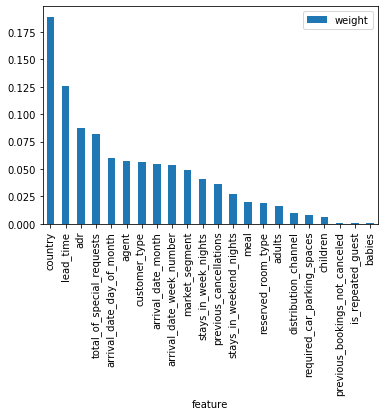

In [8]:
imp_df_final.sort_values(by = 'weight', ascending=False).head(22).plot.bar(x = 'feature')

Ahora vamos a probar eliminado las 10 variables menos importanes a ver si el modelo se sigue comportando igual.

In [9]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_week_nights","previous_cancellations","agent","adr","total_of_special_requests",
               ]
,
cat_features = ["arrival_date_month","country","market_segment","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
rf_model = RandomForestClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_rf12 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_rf12 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_rf12[0] = [tn_mean, fp_mean]
cm_rf12[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_rf12 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Random Forest accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Random Forest balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Random Forest area under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Random Forest cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Random Forest cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Random Forest cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Random Forest cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Random Forest cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Random Forest cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Random Forest cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_rf12)

Random Forest accuracy score: 0.8688 +/- 0.0031 (std) min: 0.8643, max: 0.8732
Random Forest balanced accuracy score: 0.8621 +/- 0.0041 (std) min: 0.8554, max: 0.8682
Random Forest area under ROC curve score: 0.9441 +/- 0.0034 (std) min: 0.9374, max: 0.9498
Random Forest cross validation sensitivity score: 0.8121 +/- 0.0099 (std)
Random Forest cross validation specificity score: 0.9121 +/- 0.0047 (std)
Random Forest cross validation precision score: 0.8757 +/- 0.0079 (std)
Random Forest cross validation NPV score: 0.8642 +/- 0.0062 (std)
Random Forest cross validation FNR score: 0.1879 +/- 0.0099 (std)
Random Forest cross validation FPR score: 0.0879 +/- 0.0047 (std)
Random Forest cross validation F1 score: 0.8426 +/- 0.006 (std)
[[2183.  210.]
 [ 343. 1483.]]


A continuación calcularemos la importancia de cada uno de los atributos usados. En el caso de las variables categóricas su importancia se nos dará desglosada en cada uno de sus posibles valores:

In [10]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Mostramos el número de atributos más importantes que nos interese:
imp_df_raw = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
imp_df_raw.head(25)

,feature,weight,std
0,lead_time,0.154550,0.021716
1,adr,0.112099,0.010633
2,country_PRT,0.091661,0.047792
3,total_of_special_requests,0.089423,0.023950
4,arrival_date_day_of_month,0.076870,0.004062
5,agent,0.067889,0.022770
6,arrival_date_week_number,0.058657,0.005565
7,stays_in_week_nights,0.049754,0.003627
8,previous_cancellations,0.037516,0.024179
9,customer_type_Transient,0.028478,0.020001


Hemos mostrado el dataframe anterior porque hemos pensado que podría ser interesante ver que categoría de las variables categóricas tenia más peso. No obstante, realmente nos interesa saber el resultado agregado, por lo que lo calcularemos a partir de los datos anteriores:

In [11]:
#Construimos un primer dataframe con las variables numéricas:
search_values = num_features
imp_df_num = imp_df_raw[imp_df_raw.feature.str.contains('|'.join(search_values ))].copy()
imp_df_num.drop(['std'],axis = 1, inplace = True)

#Juntamos todas las categorías de las variables categóricas:



arrival_date_month = imp_df_raw[imp_df_raw['feature'].str.contains("arrival_date_month")]

country = imp_df_raw[imp_df_raw['feature'].str.contains("country")]
market_segment = imp_df_raw[imp_df_raw['feature'].str.contains("market_segment")]


customer_type = imp_df_raw[imp_df_raw['feature'].str.contains("customer")]

#Creamos un array con las sumas:
array = np.zeros(shape=(4,1))

array[0] = arrival_date_month.weight.sum()

array[1] = country.weight.sum()
array[2] = market_segment.weight.sum()


array[3] = customer_type.weight.sum()

#Construimos un diccionario para crear un dataframe con las variables categóricasfácilmente:
dict = {'feature': [
 'arrival_date_month',

 'country',
 'market_segment',

 'customer_type']
                 , 'weight': array[:,0]}

imp_dict = pd.DataFrame(dict)

#Unimos los dos dataframes:
imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)
imp_df_final.head(22)

,feature,weight
0,lead_time,0.154550
1,adr,0.112099
2,total_of_special_requests,0.089423
3,arrival_date_day_of_month,0.076870
4,agent,0.067889
5,arrival_date_week_number,0.058657
6,stays_in_week_nights,0.049754
7,previous_cancellations,0.037516
8,arrival_date_month,0.048279
9,country,0.191211


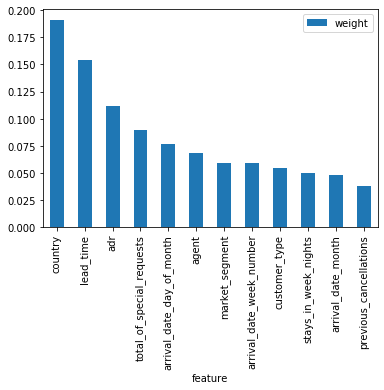

In [12]:
imp_df_final.sort_values(by = 'weight', ascending=False).head(22).plot.bar(x = 'feature')

Ahora vamos a probar eliminado las mas variables hasta quedarnos con las 4 varibles más importanes

In [13]:
#Definimos que variables son númericas y cuales son categóricas:
num_features = ["lead_time","adr","total_of_special_requests"]
,
cat_features = ["country"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Prepararamos el preprocesado. Escalaremos las variables numéricas y codificaremos las variables categóricas:
num_transformer = StandardScaler()
cat_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
#Definimos el modelo a usar:
rf_model = RandomForestClassifier()

#Usaremos 10-fold stratified CV. Al usar pipelines nos aseguramos que los datos se transformen en cada iteración.
kfold = KFold(n_splits=10, random_state=100, shuffle = True)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])
cv_results = cross_validate(model_pipe, 
                                 X_train, y_train, 
                                 cv=kfold,
                                 scoring={'accuracy': 'accuracy','balanced_accuracy': 'balanced_accuracy','roc_auc': 'roc_auc','tp': make_scorer(tp), 'tn': make_scorer(tn),
'fp': make_scorer(fp), 'fn': make_scorer(fn)},
                                 n_jobs=-1)
#Mostramos los resultados:
model_results_rf4 = np.zeros(shape=(1,7))
accuracy_array =  cv_results['test_accuracy']
balanced_accuracy_array =  cv_results['test_balanced_accuracy']
roc_auc_array = cv_results['test_roc_auc']


min_score_acc = round(min(accuracy_array), 4)
max_score_acc = round(max(accuracy_array), 4)
mean_score_acc = round(np.mean(accuracy_array), 4)
std_dev_acc = round(np.std(accuracy_array), 4)

min_score_bal_acc = round(min(balanced_accuracy_array), 4)
max_score_bal_acc = round(max(balanced_accuracy_array), 4)
mean_score_bal_acc = round(np.mean(balanced_accuracy_array), 4)
std_dev_bal_acc = round(np.std(balanced_accuracy_array), 4)

min_score_roc_auc = round(min(roc_auc_array), 4)
max_score_roc_auc = round(max(roc_auc_array), 4)
mean_score_roc_auc = round(np.mean(roc_auc_array), 4)
std_dev_roc_auc = round(np.std(roc_auc_array), 4)

sensitivity = np.zeros(shape=(1,10))
specificity = np.zeros(shape=(1,10))
precision = np.zeros(shape=(1,10))
NPV = np.zeros(shape=(1,10))
FNR = np.zeros(shape=(1,10))
FPR = np.zeros(shape=(1,10))
F1 = np.zeros(shape=(1,10))

#Construimos la matriz de confusión:
cm_rf4 = np.zeros(shape=(2,2))

tp_array = cv_results['test_tp']
tn_array = cv_results['test_tn']
fp_array = cv_results['test_fp']
fn_array = cv_results['test_fn']
    
tn_mean = (tn_array.mean()).astype(np.int64)
fp_mean = (fp_array.mean()).astype(np.int64)
fn_mean = (fn_array.mean()).astype(np.int64)
tp_mean = (tp_array.mean()).astype(np.int64)

cm_rf4[0] = [tn_mean, fp_mean]
cm_rf4[1] = [fn_mean, tp_mean]

j=0
while j < 10:
    sensitivity[0,j] = tp_array[j]/(tp_array[j]+fn_array[j])
    specificity[0,j] = tn_array[j]/(tn_array[j]+fp_array[j])
    precision[0,j] = tp_array[j]/(tp_array[j]+fp_array[j])
    NPV[0,j] = tn_array[j]/(tn_array[j]+fn_array[j])
    FNR[0,j] = 1-tp_array[j]/(tp_array[j]+fn_array[j])
    FPR[0,j] = 1-tn_array[j]/(tn_array[j]+fp_array[j])
    F1[0,j] = 2*tp_array[j]/(2*tp_array[j]+fp_array[j]+fn_array[j])
    j=j+1
    
        
sd_sensitivity = round(np.std(sensitivity), 4)
sd_specificity = round(np.std(specificity), 4)
sd_precision = round(np.std(precision), 4)
sd_NPV = round(np.std(NPV), 4)
sd_FNR = round(np.std(FNR), 4)
sd_FPR = round(np.std(FPR), 4)
sd_F1 = round(np.std(F1), 4)
    
sensitivity_mean = round(sensitivity.mean(),4)
specificity_mean = round(specificity.mean(),4)
precision_mean = round(precision.mean(),4)
NPV_mean = round(NPV.mean(),4)
FNR_mean = round(FNR.mean(),4)
FPR_mean = round(FPR.mean(),4)
F1_mean = round(F1.mean(),4)


model_results_rf4 = np.array([mean_score_acc,mean_score_bal_acc,mean_score_roc_auc,tn_mean,fp_mean,fn_mean,tp_mean])

print(f"Random Forest accuracy score: {mean_score_acc} +/- {std_dev_acc} (std) min: {min_score_acc}, max: {max_score_acc}")
print(f"Random Forest balanced accuracy score: {mean_score_bal_acc} +/- {std_dev_bal_acc} (std) min: {min_score_bal_acc}, max: {max_score_bal_acc}")
print(f"Random Forest area under ROC curve score: {mean_score_roc_auc} +/- {std_dev_roc_auc} (std) min: {min_score_roc_auc}, max: {max_score_roc_auc}")
print(f"Random Forest cross validation sensitivity score: {sensitivity_mean} +/- {sd_sensitivity} (std)")
print(f"Random Forest cross validation specificity score: {specificity_mean} +/- {sd_specificity} (std)")
print(f"Random Forest cross validation precision score: {precision_mean} +/- {sd_precision} (std)")
print(f"Random Forest cross validation NPV score: {NPV_mean} +/- {sd_NPV} (std)")
print(f"Random Forest cross validation FNR score: {FNR_mean} +/- {sd_FNR} (std)")
print(f"Random Forest cross validation FPR score: {FPR_mean} +/- {sd_FPR} (std)")
print(f"Random Forest cross validation F1 score: {F1_mean} +/- {sd_F1} (std)")
print(cm_rf4)

Random Forest accuracy score: 0.8119 +/- 0.0042 (std) min: 0.8045, max: 0.8213
Random Forest balanced accuracy score: 0.8038 +/- 0.0053 (std) min: 0.7942, max: 0.8152
Random Forest area under ROC curve score: 0.8922 +/- 0.0047 (std) min: 0.8843, max: 0.9013
Random Forest cross validation sensitivity score: 0.743 +/- 0.0116 (std)
Random Forest cross validation specificity score: 0.8645 +/- 0.0049 (std)
Random Forest cross validation precision score: 0.807 +/- 0.0094 (std)
Random Forest cross validation NPV score: 0.8151 +/- 0.0071 (std)
Random Forest cross validation FNR score: 0.257 +/- 0.0116 (std)
Random Forest cross validation FPR score: 0.1355 +/- 0.0049 (std)
Random Forest cross validation F1 score: 0.7736 +/- 0.0081 (std)
[[2069.  324.]
 [ 469. 1357.]]


A continuación calcularemos la importancia de cada uno de los atributos usados. En el caso de las variables categóricas su importancia se nos dará desglosada en cada uno de sus posibles valores:

In [14]:
#Ajustamos el modelo para poder acceder a los valores:
model_pipe.fit(X_train,y_train)

#Necesitamos los nombres de los atributos codificados. Los obtenemos de One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

#Añadimos los atributos numéricos para tener la lista de atributos completa
feat_imp_list = num_features + onehot_columns

#Mostramos el número de atributos más importantes que nos interese:
imp_df_raw = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
imp_df_raw.head(25)

,feature,weight,std
0,lead_time,0.365405,0.016366
1,adr,0.338434,0.012471
2,country_PRT,0.095617,0.046261
3,total_of_special_requests,0.095512,0.028882
4,country_DEU,0.016561,0.010763
5,country_FRA,0.015783,0.012574
6,country_ESP,0.004783,0.004363
7,country_GBR,0.004232,0.003012
8,country_AGO,0.003325,0.001043
9,country_CHN,0.003255,0.001356


Hemos mostrado el dataframe anterior porque hemos pensado que podría ser interesante ver que categoría de las variables categóricas tenia más peso. No obstante, realmente nos interesa saber el resultado agregado, por lo que lo calcularemos a partir de los datos anteriores:

In [15]:
#Construimos un primer dataframe con las variables numéricas:
search_values = num_features
imp_df_num = imp_df_raw[imp_df_raw.feature.str.contains('|'.join(search_values ))].copy()
imp_df_num.drop(['std'],axis = 1, inplace = True)

#Juntamos todas las categorías de las variables categóricas:





country = imp_df_raw[imp_df_raw['feature'].str.contains("country")]


#Creamos un array con las sumas:
array = np.zeros(shape=(1,1))


array[0] = country.weight.sum()


#Construimos un diccionario para crear un dataframe con las variables categóricasfácilmente:
dict = {'feature': [ 'country']
                 , 'weight': array[:,0]}

imp_dict = pd.DataFrame(dict)

#Unimos los dos dataframes:
imp_df_final = imp_df_num.append(imp_dict,ignore_index = True)
imp_df_final.head(22)

,feature,weight
0,lead_time,0.365405
1,adr,0.338434
2,total_of_special_requests,0.095512
3,country,0.200649


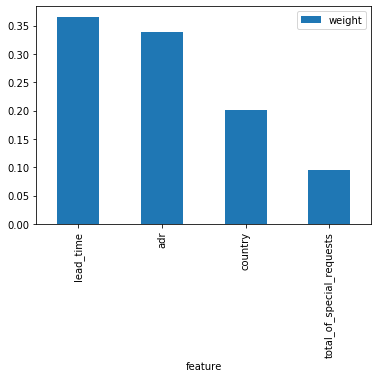

In [16]:
imp_df_final.sort_values(by = 'weight', ascending=False).head(22).plot.bar(x = 'feature')

In [17]:
#Juntamos los resultados obtenidos con cada modelo:
rf_parameters = np.zeros(shape=(3,7))
rf_parameters[0] = model_results_rf22
rf_parameters[1] = model_results_rf12
rf_parameters[2] = model_results_rf4

#Creamos un diccionario para pasar los resultados a un dataframe:
rf_parameters_dict = {'Model': ['RF 22 var', 'RF 12 var', 'RF 4 var']
                 , 'Accuracy': rf_parameters[:,0],'Balanced accuracy': rf_parameters[:,1],'ROC AUC': rf_parameters[:,2],'TN': rf_parameters[:,3],'FP': rf_parameters[:,4],'FN': rf_parameters[:,5],'TP': rf_parameters[:,6]}

rf_parameters_df = pd.DataFrame.from_dict(rf_parameters_dict)
rf_parameters_df

,Model,Accuracy,Balanced accuracy,ROC AUC,TN,FP,FN,TP
0,RF 22 var,0.8719,0.8646,0.9466,2198.0,195.0,345.0,1481.0
1,RF 12 var,0.8688,0.8621,0.9441,2183.0,210.0,343.0,1483.0
2,RF 4 var,0.8119,0.8038,0.8922,2069.0,324.0,469.0,1357.0


Text(0.5, 1.0, 'Area under ROC curve VS # of variables')

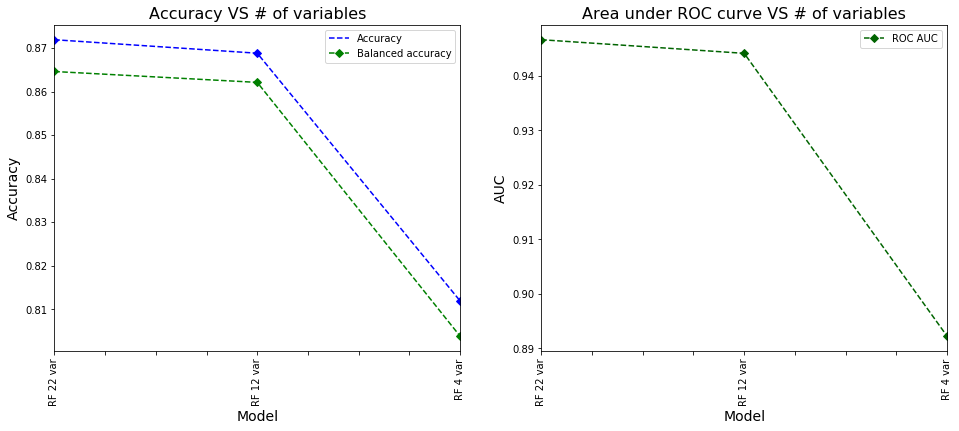

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,6))
a = rf_parameters_df.plot(kind='line',x='Model',y='Accuracy',ax=ax1, rot = 90, color = 'blue',linestyle ='--', marker='D')
rf_parameters_df.plot(kind='line',x='Model',y='Balanced accuracy', color='green', ax=ax1, rot = 90,linestyle ='--', marker='D')
a.set_title('Accuracy VS # of variables', fontsize = 16)
a.set_xlabel('Model', fontsize = 14)
a.set_ylabel('Accuracy', fontsize = 14)

b = rf_parameters_df.plot(kind='line',x='Model',y='ROC AUC', rot = 90, color = 'DarkGreen',linestyle ='--', marker='D',ax=ax2)
b.set_xlabel('Model', fontsize = 14)
b.set_ylabel('AUC', fontsize = 14)
plt.title('Area under ROC curve VS # of variables', fontsize = 16)

Nos quedamos con el modelo de 12 variables

### 8.3 Ajustar hiperparametros

In [20]:
#Nos hemos quedado con el modelo de 12 variables
num_features = ["lead_time","arrival_date_week_number", "arrival_date_day_of_month","stays_in_week_nights","previous_cancellations","agent","adr","total_of_special_requests"]

cat_features = ["arrival_date_month","country","market_segment","customer_type"]


features = num_features + cat_features

#Definimos nuestros atributos y nuestra variable respuesta:
X = df_final.drop(["is_canceled"], axis=1)[features]
Y = df_final["is_canceled"]


#Codificamos las variables categóricas:
ct = make_column_transformer(
    (OneHotEncoder(),cat_features), remainder = 'passthrough')

#Convertimos X en un array:
X = ct.fit_transform(X).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [21]:
X_train.shape

(42209, 196)

#### 8.3.1 n_estimators

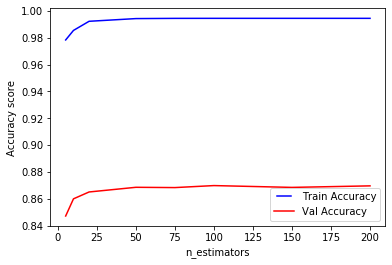

In [22]:
estimadores = [5,10,20,50,75,100,150,200]
train_results = []
test_results = []
for estimador in estimadores:
    dt = RandomForestClassifier(n_estimators=estimador)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train Accuracy")
line2, = plt.plot(estimadores, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("n_estimators")
plt.show()

iteracion 5 realizada
iteracion 10 realizada
iteracion 20 realizada
iteracion 50 realizada
iteracion 75 realizada


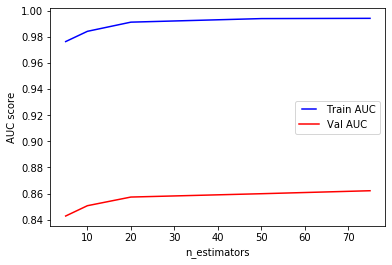

In [23]:
estimadores = [5,10,20,50,75]
train_results = []
test_results = []
for estimador in estimadores:
    dt = RandomForestClassifier(n_estimators=estimador)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", estimador, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train AUC")
line2, = plt.plot(estimadores, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

Nos quedamos con el valor el valor n_estimadors=100.

In [24]:
grid_param = {
    'n_estimators': [5,10,20,50,75,100,150,200]}

In [28]:
gd_sr = sklearn.model_selection.GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)

In [29]:
gd_sr.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [30]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'n_estimators': 200}


Nos da como mejor n_estimators 200, pero la diferencia con el valor 100 es infimo y el coste computacional es mucho menor.

#### 8.3.2 Max_depth

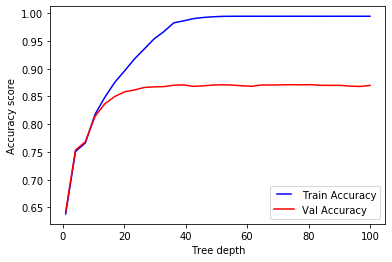

In [32]:
max_depths = np.linspace(1, 100, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = RandomForestClassifier max_depth=max_depth)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train Accuracy")
line2, = plt.plot(max_depths, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("Tree depth")
plt.show()

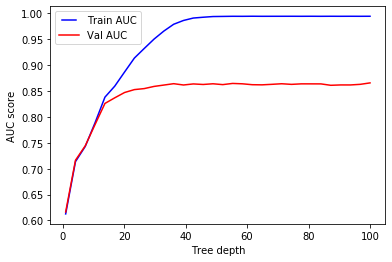

In [36]:
max_depths = np.linspace(1, 100, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = RandomForestClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

In [35]:
grid_param = {
    'max_depth': [5,10,20,50,75,100,150,200]}
gd_sr = sklearn.model_selection.GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 200}


Nos quedamos con el valor max_depth=100. Es el valor que estaba por defecto

#### 8.3.3 max_features

iteration 0.1 hecha
iteration 0.2 hecha
iteration 0.3 hecha
iteration 0.4 hecha
iteration 0.5 hecha
iteration 0.6 hecha
iteration 0.7 hecha
iteration 0.8 hecha
iteration 0.9 hecha
iteration 1.0 hecha


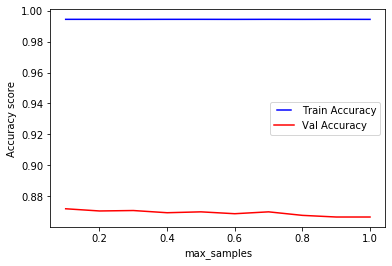

In [39]:
max_features = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_results = []
test_results = []
for max_feature in max_features:
    dt = RandomForestClassifier(max_depth=100, max_features= max_feature)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
    print("iteration", max_feature, "hecha")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, "b", label="Train Accuracy")
line2, = plt.plot(max_features, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("max_samples")
plt.show()

iteracion 0.1 realizada
iteracion 0.2 realizada
iteracion 0.3 realizada
iteracion 0.4 realizada
iteracion 0.5 realizada
iteracion 0.6 realizada
iteracion 0.7 realizada
iteracion 0.8 realizada
iteracion 0.9 realizada
iteracion 1.0 realizada


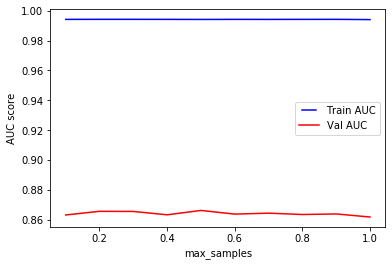

In [41]:
max_features = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_results = []
test_results = []
for max_feature in max_features:
    dt = RandomForestClassifier(max_depth=100, max_features= max_feature)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", max_feature, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, "b", label="Train AUC")
line2, = plt.plot(max_features, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_samples")
plt.show()

In [42]:
grid_param = {
    'max_features': [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
gd_sr = sklearn.model_selection.GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_features': 0.2}


Nos quedamos con el valor que de max_features de 0,2.

#### 8.3.4 max_samples

iteration 0.1 hecha
iteration 0.2 hecha
iteration 0.3 hecha
iteration 0.4 hecha
iteration 0.5 hecha
iteration 0.6 hecha
iteration 0.7 hecha
iteration 0.8 hecha
iteration 0.9 hecha
iteration 0.99 hecha


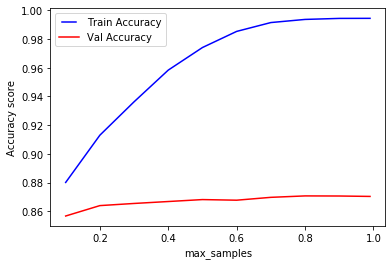

In [45]:
max_samples = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
train_results = []
test_results = []
for max_sample in max_samples:
    dt = RandomForestClassifier(max_depth=100, max_features=0.2 , max_samples= max_sample)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
    print("iteration", max_sample, "hecha")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_samples, train_results, "b", label="Train Accuracy")
line2, = plt.plot(max_samples, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("max_samples")
plt.show()

iteracion 0.1 realizada
iteracion 0.2 realizada
iteracion 0.3 realizada
iteracion 0.4 realizada
iteracion 0.5 realizada
iteracion 0.6 realizada
iteracion 0.7 realizada
iteracion 0.8 realizada
iteracion 0.9 realizada
iteracion 0.99 realizada


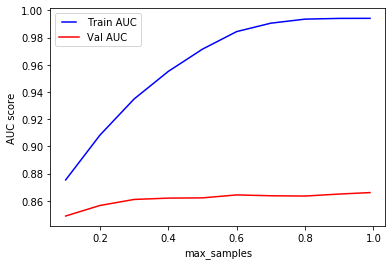

In [46]:
max_samples = [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
train_results = []
test_results = []
for max_sample in max_samples:
    dt = RandomForestClassifier(max_depth=100, max_features=0.2 , max_samples= max_sample)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
    print("iteracion", max_sample, "realizada")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_samples, train_results, "b", label="Train AUC")
line2, = plt.plot(max_samples, test_results, "r", label="Val AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max_samples")
plt.show()

In [48]:
grid_param = {
    'max_samples': [0.1, 0.2, 0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 0.99]}
gd_sr = sklearn.model_selection.GridSearchCV(estimator=RandomForestClassifier(),
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=2,
                     n_jobs=-1)
gd_sr.fit(X_train, y_train)
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_samples': 0.7}


Se tomara el valor por defecto "none", ya que este hace referencia al valor=1. Es decir, cada bolsa tiene el mismo tamaño que los datos iniciales.

### 8.4 Modelo final

In [49]:
rf_final_model = RandomForestClassifier(max_depth=100, max_features=0.2)
rf_final_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [50]:
rf_final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
#Calculamos los valores que obtenemos de nuestros datos de test
y_pred=rf_final_model.predict(X_test)

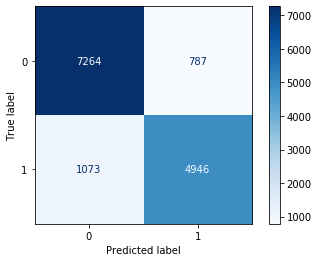

In [52]:
sklearn.metrics.plot_confusion_matrix(rf_final_model, X_test, y_test, values_format="d", cmap=plt.cm.Blues)  # doctest: +SKIP
plt.show()

In [61]:
accuracy= sklearn.metrics.accuracy_score(y_test, y_pred)
accuracy_balanced= sklearn.metrics.balanced_accuracy_score(y_test, y_pred)
roc= metrics.auc(fpr, tpr)
f1= sklearn.metrics.f1_score(y_test, y_pred)

In [62]:
results_dict = {'Model': ['Random Forest']
                 , 'Accuracy': accuracy,'Balanced accuracy': accuracy_balanced,'ROC AUC': roc, 'F1 Score': f1}

model_results_df = pd.DataFrame.from_dict(results_dict)
model_results_df

,Model,Accuracy,Balanced accuracy,ROC AUC,F1 Score
0,Random Forest,0.867804,0.86199,0.945698,0.841729


In [63]:
model_results_df.to_csv('df_randomForest_final.csv', index=False)

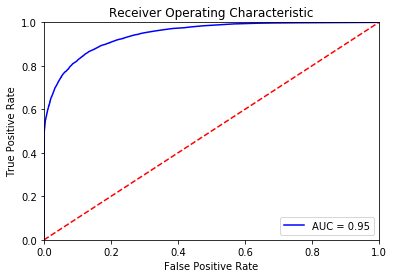

In [64]:
import sklearn.metrics as metrics
probs = rf_final_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc= metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [59]:
metrics.auc(fpr, tpr)

0.9456980605592331

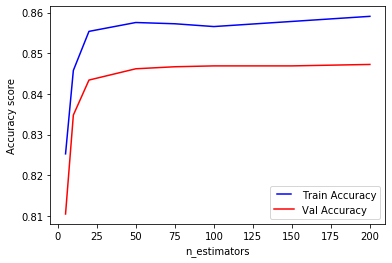

In [68]:
estimadores = [5,10,20,50,75,100,150,200]
train_results = []
test_results = []
for estimador in estimadores:
    dt = RandomForestClassifier(n_estimators=estimador, max_samples=0.1, max_depth=20)
    dt.fit(X_train, y_train)
    score=dt.score(X_train, y_train)
    # Add auc score to previous train results
    train_results.append(score)
    scoret = dt.score(X_val, y_val)
    # Add auc score to previous test results
    test_results.append(scoret)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(estimadores, train_results, "b", label="Train Accuracy")
line2, = plt.plot(estimadores, test_results, "r", label="Val Accuracy")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("n_estimators")
plt.show()

In [69]:
from sklearn.metrics import classification_report
h=classification_report(y_test, y_pred)

In [70]:
print(h)

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      8051
           1       0.86      0.82      0.84      6019

    accuracy                           0.87     14070
   macro avg       0.87      0.86      0.86     14070
weighted avg       0.87      0.87      0.87     14070



In [71]:
results_dict = {'Model': ['Random Forest']
                 , 'Accuracy': accuracy,'Balanced accuracy': accuracy_balanced,'ROC AUC': roc, 'F1 Score': f1, 'sensitivity':0.82, 'specificity':0.9}

model_results_df = pd.DataFrame.from_dict(results_dict)
model_results_df

,Model,Accuracy,Balanced accuracy,ROC AUC,F1 Score,sensitivity,specificity
0,Random Forest,0.867804,0.86199,0.945698,0.841729,0.82,0.9


In [72]:
model_results_df.to_csv('df_randomForest_final.csv', index=False)